In [10]:
import json
import numpy as np

In [11]:
from Classes_PINN import *
from Classes_NN import NN

In [12]:
def serialize_savelist(keys: list, values : list, filename):
    dict = {k: v for k, v in zip(keys, values)}
    filename = f"{filename}.json"
    with open(filename, 'w') as file:
        json.dump(dict, file)

In [13]:
# Parameters model
rho = 0.5
mu = 79300 # MPa
lam = 100000 # MPa

Lx = 0.2
Ly = 0.2
T = 0.2

x_domain = np.array([0.0, Lx])/Lx
y_domain = np.array([0.0, Ly])/Lx
t_domain = np.array([0.0, T])/T

# Parameters NN
epochs = 12000
n_train = 40
layers = 2
dim_hidden = 35
lr = 0.02
om_RESIDUAL = 0.5
om_INITIAL = 2
om_BOUNDARY = 0.4

In [14]:
pinn = PINN(layers, dim_hidden, act=nn.Tanh()).to(device)

loss_fn = Loss(
    x_domain,
    y_domain,
    t_domain,
    n_train,
    return_adim(x_domain, t_domain, rho, mu, lam),
    initial_conditions,
    om_RESIDUAL,
    om_INITIAL,
    om_BOUNDARY
)

# Import weights from pretrained model

In [15]:
filename_model = get_last_modified_file('in_model')
pretrained_model_dict = torch.load(filename_model)

pretrained_model = NN(layers, dim_hidden, 2, 1)
pretrained_model.load_state_dict(pretrained_model_dict)

<All keys matched successfully>

In [16]:
for i in np.arange(len(pinn.middle_layers)):
    pinn_layer = pinn.middle_layers[i]
    pretrained_layer = pretrained_model.middle_layers[i]
    pinn.middle_layers[i].weight.data.copy_(pretrained_model.middle_layers[i].weight)
    pinn.middle_layers[i].bias.data.copy_(pretrained_model.middle_layers[i].bias)

# Eventually save changed $NN_2$ parameters to pass to other script

In [17]:
par = [Lx, T, n_train, layers, dim_hidden]
keys = ['x', 't', 'n', 'n_layers', 'n_neurons']

serialize_savelist(keys, par, 'par')

# Train new network with pretrained weights and biases in middle layers

In [18]:
pinn_trained, loss_values = train_model(
    pinn, loss_fn=loss_fn, learning_rate=lr, max_epochs=epochs)

Folder '2024-04-24' created.


Loss: 857829539840.0000:   0%|          | 1/12000 [00:02<7:24:43,  2.22s/it]

KeyboardInterrupt: 

In [10]:
current_time = get_current_time()
hour_minute_str = current_time.strftime("%H:%M")

folder = 'model'
model_name = f'{lr}_{epochs}_{dim_hidden}_{hour_minute_str}.pth'
model_path = os.path.join(folder, model_name)
os.makedirs(folder, exist_ok=True)

torch.save(pinn.state_dict(), model_path)

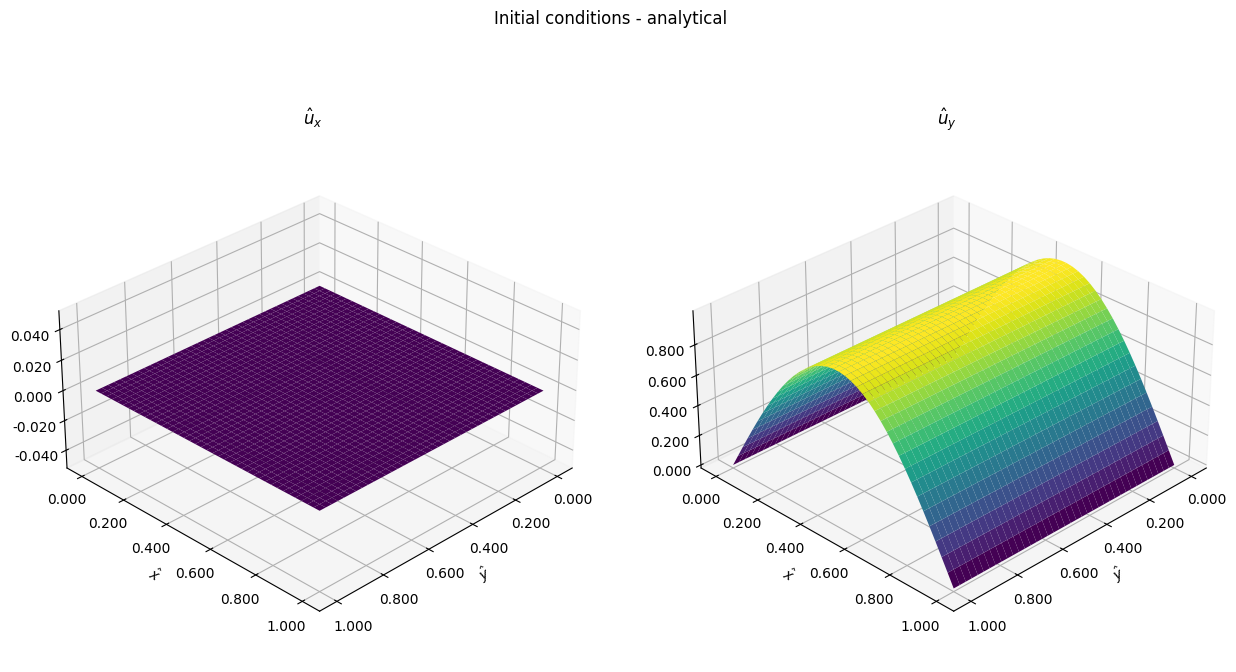

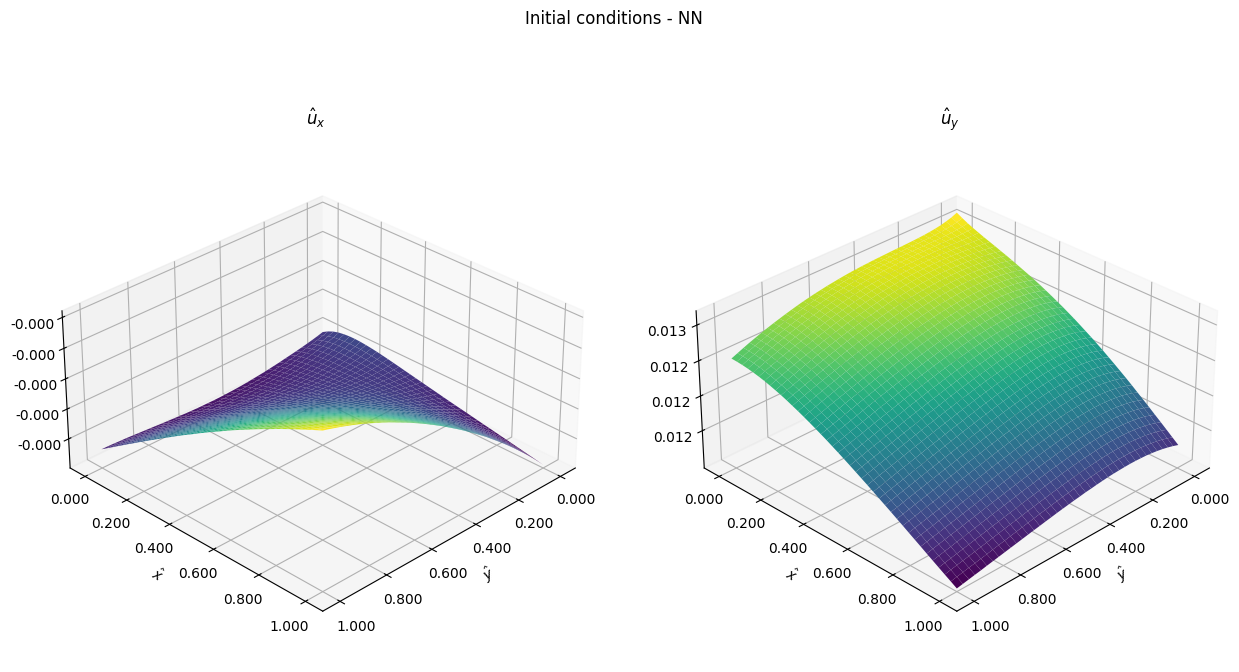

In [16]:
x, y, _ = get_initial_points(x_domain, y_domain, t_domain, n_train)
t_value = 0.0
t = torch.full_like(x, t_value)
x = x.to(device)
y = y.to(device)
t = t.to(device)
z = f(pinn, x ,y, t)
ux_0, uy_0 = initial_conditions(x, y, x[-1], i = 1)
z_0 = torch.cat((ux_0, uy_0), dim=1)
plot_initial_conditions(z_0, y, x, 'Initial conditions - analytical', n_train, from_pinn = 0)
plot_initial_conditions(z, y, x, 'Initial conditions - NN', n_train)

In [ ]:
!tensorboard --logdir logs

# To be added
- ~separate loss in more bars to see how the various loss term come to zero~
- see if some quadrature rule has been implemented
- scheme of weights initialization in order to automatically satisfy initial conditions
- plots (in progress)
- NN operators (to generalize results)
- try to implement function that allows that satisfy initial conditions?

# To be fully understood
- reshape when plotting (also different number of points allowed?)
- ~not consistent initial conditions~ (between $u_x$ and $u_y$)?